In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from utils.logger import Logger
import models.model_picker as mp
import params.param_picker as pp
import utils.plot_functions as pf
from data.nat_dataset import Dataset

In [2]:
def normalizer(x, x_max, x_min, new_min, new_max): 
  return (((x-x_min)/(x_max-x_min))*(new_max-new_min)+new_min)

In [3]:
enc_model_name = "conv_gdn_autoencoder_dropout"
enc_model_version = "1.0"
weight_locs = ["/home/dpaiton/Work/Projects/"+enc_model_name+"/analysis/"+enc_model_version+"/b3.npz",
"/home/dpaiton/Work/Projects/"+enc_model_name+"/analysis/"+enc_model_version+"/b4.npz",
"/home/dpaiton/Work/Projects/"+enc_model_name+"/analysis/"+enc_model_version+"/b5.npz",
"/home/dpaiton/Work/Projects/"+enc_model_name+"/analysis/"+enc_model_version+"/b_gdn3.npz",
"/home/dpaiton/Work/Projects/"+enc_model_name+"/analysis/"+enc_model_version+"/b_gdn4.npz",
"/home/dpaiton/Work/Projects/"+enc_model_name+"/analysis/"+enc_model_version+"/w3.npz",
"/home/dpaiton/Work/Projects/"+enc_model_name+"/analysis/"+enc_model_version+"/w4.npz",
"/home/dpaiton/Work/Projects/"+enc_model_name+"/analysis/"+enc_model_version+"/w5.npz",
"/home/dpaiton/Work/Projects/"+enc_model_name+"/analysis/"+enc_model_version+"/w_gdn3.npz",
"/home/dpaiton/Work/Projects/"+enc_model_name+"/analysis/"+enc_model_version+"/w_gdn4.npz"]
weights = [np.load(file)["data"] for file in weight_locs]
print([weight.shape for weight in weights])

[(64,), (128,), (1,), (64,), (128,), (4, 4, 64, 28), (9, 9, 128, 64), (8, 8, 1, 128), (64, 64), (128, 128)]


In [4]:
target_r = np.stack([np.load("/home/dpaiton/IEDM/image_rram_encoding-"+str(img_id)+".npz")["data"]
  for img_id in range(3)], axis=0)
post_mem_r = np.stack([np.load("/home/dpaiton/IEDM/post_mem_r-"+str(img_id)+".npz")["data"]
  for img_id in range(3)], axis=0)

In [5]:
post_mem_r[0,...].shape

(4, 4, 28)

In [6]:
model_type = "conv_gdn_decoder"
model_name = "conv_gdn_decoder"
model_version = "0.0"

params = pp.get_params(model_type)
params.batch_size = 3
model = mp.get_model(model_type)
model.setup(params)

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
with tf.compat.v1.Session(config=config, graph=model.graph) as sess:
  # Need to provide shape if batch_size is used in graph
  feed_dict={model.x:np.zeros([model.batch_size]+model.input_shape, dtype=np.float32)}
  
  for idx, b_array in enumerate(weights[0:3]):
    feed_dict[model.b_init_list[idx]] = b_array
    
  for idx, b_igdn_array in enumerate(weights[3:5]):
    feed_dict[model.b_igdn_init_list[idx]] = b_igdn_array
    
  for idx, w_array in enumerate(weights[5:8]):
    feed_dict[model.w_init_list[idx]] = w_array
    
  for idx, w_igdn_array in enumerate(weights[8:]):
    feed_dict[model.w_igdn_init_list[idx]] = w_igdn_array
    
  sess.run(model.init_op, feed_dict=feed_dict)
  
  feed_dict[model.x] = target_r
  #feed_dict[model.x] = post_mem_r
  
  recon = sess.run(model.u_list[-1], feed_dict)


11/19/18 17:41:24 -- <params>{
  "batch_size": 3,
  "data_dir": "/home/dpaiton/Work/Datasets/",
  "data_file": "/media/tbell/datasets/verified_images.txt",
  "device": "/gpu:0",
  "eps": 1e-12,
  "gdn_b_init_const": 0.1,
  "gdn_b_thresh_min": 0.001,
  "gdn_eps": 1e-06,
  "gdn_w_init_const": 0.1,
  "gdn_w_thresh_min": 0.001,
  "input_channels": [
    28,
    64,
    128
  ],
  "input_shape": [
    4,
    4,
    28
  ],
  "model_name": "conv_gdn_decoder",
  "model_type": "conv_gdn_decoder",
  "out_dir": "/home/dpaiton/Work/Projects/",
  "output_channels": [
    64,
    128,
    1
  ],
  "patch_size_x": [
    4,
    9,
    8
  ],
  "patch_size_y": [
    4,
    9,
    8
  ],
  "rand_seed": 1234567890,
  "strides": [
    2,
    2,
    4
  ],
  "version": "0.0"
}</params>

11/19/18 17:41:24 -- <schedule>null</schedule>


In [7]:
#input_file = "/home/dpaiton/tmp_file_loc.txt"
#data_params = {}
#data_params["rand_state"] = np.random.RandomState(1)
#data_params["data_shape"] = [128,128,1]
#data = {"train": Dataset(input_file, data_params)}
#data_batch = data["train"].next_batch(model.batch_size)
#input_data = data_batch[0][0,...]

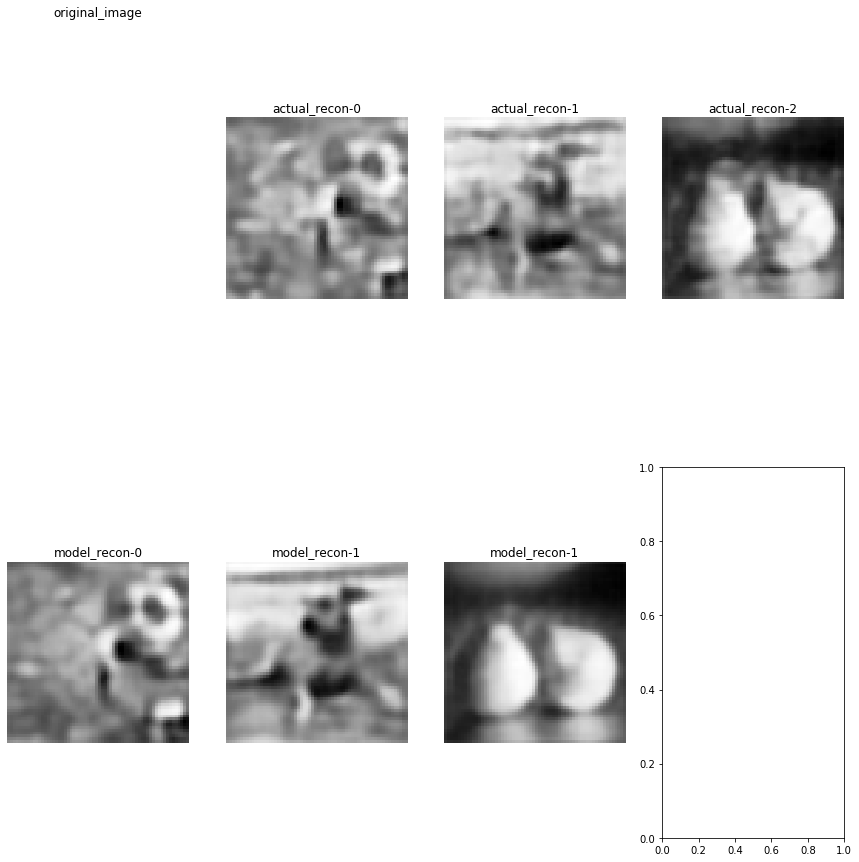

In [8]:
fig, ax = plt.subplots(2, 4, figsize=(15,15))
ax[0,0] = pf.clear_axis(ax[0,0])
#ax[0,0].imshow(np.squeeze(input_data), cmap="Greys_r")
ax[0,0].set_title("original_image")

ax[0,1] = pf.clear_axis(ax[0,1])
img = np.load("/home/dpaiton/IEDM/image_recon-0.npz")["data"]
ax[0,1].imshow(np.squeeze(img), cmap="Greys_r")
ax[0,1].set_title("actual_recon-0")

ax[0,2] = pf.clear_axis(ax[0,2])
img = np.load("/home/dpaiton/IEDM/image_recon-1.npz")["data"]
ax[0,2].imshow(np.squeeze(img), cmap="Greys_r")
ax[0,2].set_title("actual_recon-1")

ax[0,3] = pf.clear_axis(ax[0,3])
img = np.load("/home/dpaiton/IEDM/image_recon-2.npz")["data"]
ax[0,3].imshow(np.squeeze(img), cmap="Greys_r")
ax[0,3].set_title("actual_recon-2")

ax[1,0] = pf.clear_axis(ax[1,0])
ax[1,0].imshow(np.squeeze(recon[0,...]), cmap="Greys_r")
ax[1,0].set_title("model_recon-0")

ax[1,1] = pf.clear_axis(ax[1,1])
ax[1,1].imshow(np.squeeze(recon[1, ...]), cmap="Greys_r")
ax[1,1].set_title("model_recon-1")

ax[1,2] = pf.clear_axis(ax[1,2])
ax[1,2].imshow(np.squeeze(recon[2, ...]), cmap="Greys_r")
ax[1,2].set_title("model_recon-1")


plt.show()